# Prequisite

## Libraries

In [1]:
# Comment if trained locally, uncomment if trained on GCP
# !pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchtext==0.14.1 torchaudio==0.13.1 torchdata==0.5.1 --extra-index-url https://download.pytorch.org/whl/cu117

In [2]:
# !pip install torchvision==0.16.0 --q
# !pip install opencv-python --q

In [3]:
# pip install openpyxl

In [4]:
import os
import pandas as pd
import numpy as np
import cv2

import PIL
from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as T
import torchvision.models as models

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [5]:
print("PyTorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

PyTorch version: 2.1.0
torchvision version: 0.16.0


In [46]:
ROOT = '../../dataset/v1'

In [7]:
# Uncomment if trained on GCP
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Uncomment if trained locally
device = torch.device("mps")
print(device)

mps


In [8]:
MOD_DICT = {
    1: 'EfficientNet'
    , 2: 'MobileNet'
    , 3: 'ShuffleNet'
    , 4: 'EfficientNet-b5'
    , 5: 'EfficientNet-b7'
}

## Dataset

### Dataset Class and Functions

In [9]:
def crop_face(image_path, target_width=300, target_height=400):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (target_width, target_height))

    if image is None:
        raise ValueError("Unable to load the image from the given path.")

    face_cascade = cv2.CascadeClassifier("../../haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5)

    if len(faces) > 0:
        x, y, w, h = faces[0]
        padding = int(max(0.15*(x+w), 0.15*(y+h)))

        width_scale, height_scale = target_width / w, target_height / h
        scale = min(width_scale, height_scale)

        resized_face = cv2.resize(image[y-30:y+h+30, x:x+w], None, fx=scale, fy=scale)
        image = resized_face

    return image, cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [10]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root, transform=None):
        self.dataframe = dataframe
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.dataframe.iloc[idx, 0])
        image, _ = crop_face(img_path)
        image = Image.fromarray(image)
        if self.transform: image = self.transform(image)

        numerical_features = np.array(
            [float(self.dataframe.iloc[idx, i]) for i in range(2, 138)], dtype=np.float32
        )
        
        label = int(self.dataframe.iloc[idx, 1])

        return image, numerical_features, label

### Processes

In [11]:
df = pd.read_excel('../../dataset/df_cls.xlsx')
df.dropna()
df.head()

,nama,tampak_depan_root,full_depan,tampak_samping_root,full_samping,tampak_senyum_root,full_senyum,tipe,simetris,seimbang,transversal,profil,nasolabial,mentolabial,segaris,bukal,kurva,garis
0,aisyahi,tampak_depan,tampak_depan/aisyahi.jpg,tampak_samping,tampak_samping/aisyahi.jpg,tampak_senyum,tampak_senyum/aisyahi.jpg,doliko,asimetris,tidak,tidak,cekung,normal,lebar,ya,lebar,datar,tinggi
1,alfira,tampak_depan,tampak_depan/alfira.jpg,tampak_samping,tampak_samping/alfira.jpg,tampak_senyum,tampak_senyum/alfira.jpg,doliko,simetris,ya,ya,cembung,tajam,tumpul,ya,sedang,konsonan,rendah
2,despasya,tampak_depan,tampak_depan/despasya.jpg,tampak_samping,tampak_samping/despasya.jpg,tampak_senyum,tampak_senyum/despasya.jpg,doliko,simetris,ya,tidak,cembung,tajam,tumpul,ya,lebar,datar,sedang
3,galuh,tampak_depan,tampak_depan/galuh.jpg,tampak_samping,tampak_samping/galuh.jpg,tampak_senyum,tampak_senyum/galuh.jpg,doliko,simetris,ya,ya,cekung,tajam,tumpul,ya,leabar,konsonan,tinggi
4,happy,tampak_depan,tampak_depan/happy.jpg,tampak_samping,tampak_samping/happy.jpg,tampak_senyum,tampak_senyum/happy.jpg,brachy,simetris,ya,tidak,cembung,normal,tumpul,tidak,sedang,datar,rendah


In [12]:
TASKS = [
    'tipe', 'simetris', 'seimbang', 'transversal'
    , 'profil', 'nasolabial', 'mentolabial', 'segaris'
    , 'bukal', 'kurva', 'garis'
]
df_tasks_dict = {}

for task in TASKS:
    if task in ['tipe', 'seimbang', 'simetris', 'transversal']:
        df_tasks_dict[task] = df[['full_depan', task]]
    elif task in ['profil', 'nasolabial', 'mentolabial']:
        df_tasks_dict[task] = df[['full_samping', task]]
    else: df_tasks_dict[task] = df[['full_senyum', task]]

In [13]:
desired_size = (300, 400)

train_transform = T.Compose([
    T.Resize(desired_size),
    T.ToTensor()
])

val_transform = T.Compose([
    T.Resize(desired_size),
    T.ToTensor()
])

### Add Facial Landmarks Features

In [14]:
import dlib
import cv2
import numpy as np

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [15]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../../shape_predictor_68_face_landmarks.dat")

In [16]:
df_additional = pd.read_excel('../../dataset/df_cls.xlsx')[['nama', 'full_depan', 'tipe']]
df_additional['path'] = ROOT + '/' + df_additional['full_depan']
df_additional.sample(5)

,nama,full_depan,tipe,path
46,28,tampak_depan/28.jpg,doliko,../../dataset/v1/tampak_depan/28.jpg
37,19,tampak_depan/19.jpg,brachy,../../dataset/v1/tampak_depan/19.jpg
12,qonita,tampak_depan/qonita.jpg,doliko,../../dataset/v1/tampak_depan/qonita.jpg
13,rini,tampak_depan/rini.jpg,brachy,../../dataset/v1/tampak_depan/rini.jpg
10,nadya,tampak_depan/nadya.jpg,meso,../../dataset/v1/tampak_depan/nadya.jpg


In [17]:
flat_arrays = []
for idx in range(df_additional.shape[0]):
    image, gray = crop_face(df_additional['path'][idx])
    faces = detector(image)
    landmarks = predictor(gray, faces[0])
    landmarks_array = np.array([(landmark.x, landmark.y) for landmark in landmarks.parts()])

    flat_array = landmarks_array.flatten()
    flat_arrays.append(flat_array)

df_landmarks = pd.DataFrame(flat_arrays, columns=[f"Feature_{i + 1}" for i in range(len(flat_array))])
df_landmarks['full_depan'] = df_additional['full_depan']
df_landmarks.sample(5)

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_128,Feature_129,Feature_130,Feature_131,Feature_132,Feature_133,Feature_134,Feature_135,Feature_136,full_depan
23,13,160,15,194,20,228,26,261,37,293,...,290,192,289,162,291,149,293,138,292,tampak_depan/4.jpg
3,38,167,40,199,44,230,49,263,58,293,...,296,183,295,158,299,147,301,136,299,tampak_depan/galuh.jpg
44,28,155,31,187,37,218,43,248,53,276,...,276,184,277,162,276,151,278,140,276,tampak_depan/26.jpg
45,39,160,41,189,44,217,49,245,59,272,...,267,179,266,160,268,151,269,143,269,tampak_depan/27.jpg
6,41,149,44,180,49,212,56,242,67,269,...,268,190,270,165,270,152,272,139,270,tampak_depan/hiqmatul.jpg


# Helper Function(s)

In [18]:
class FKGTask:
    def __init__(self, face_side, subtask, data):
        self.face_side = face_side
        self.subtask = subtask
        self.dataframe, self.encoding_dict = self._get_dataframe(data, self.subtask)
        self.X, self.y = self._get_x_and_y()

    def _get_dataframe(self, data, subtask):
        encoder = OrdinalEncoder()
        unique_values = data[subtask][subtask].unique().reshape(-1, 1)
        encoder.fit(unique_values)

        before_val = data[subtask][subtask]
        data[subtask][subtask] = encoder.transform(data[subtask][subtask].values.reshape(-1, 1))
        encoding_dict = {original_class: encoded_value for original_class, encoded_value in zip(data[subtask][subtask], before_val)}
        encoding_dict = {v: k for k, v in encoding_dict.items()}
        
        return data[subtask], encoding_dict

    def _get_x_and_y(self):
        X = self.dataframe[self.face_side]
        y = self.dataframe[self.subtask]

        return X, y

    def get_train_test_split(self):
        X_train, X_val, y_train, y_val = train_test_split(
            self.X, self.y
            , stratify=self.y
            , test_size=0.2
            , random_state=42
        )

        return pd.concat([X_train, y_train], axis=1), pd.concat([X_val, y_val], axis=1)

# Modeling

In [19]:
model_ckp = {
    'effnet': '../../pretrained_ckp/efficientnet_b0_rwightman-3dd342df.pth'
    , 'shufflenet': '../../pretrained_ckp/shufflenetv2_x1-5666bf0f80.pth'
    , 'resnet':'../../pretrained_ckp/shufflenetv2_x1-5666bf0f80.pth'
    , 'mobilenet': '../../pretrained_ckp/mobilenet_v2-b0353104.pth'
}

In [20]:
def load_model_checkpoint(model, ckp_path):
    temp_model = model
    checkpoint = torch.load(ckp_path)
    temp_model.load_state_dict(checkpoint)

    return temp_model

def get_models():
    efficientnet_b0 = load_model_checkpoint(models.efficientnet_b0(pretrained=False), model_ckp['effnet'])  
    shufflenet = load_model_checkpoint(models.shufflenet_v2_x1_0(pretrained=False), model_ckp['shufflenet'])
    mobilenet_v2 = load_model_checkpoint(models.mobilenet_v2(pretrained=False), model_ckp['mobilenet'])

    model_dict = {}
    model_dict['effnet'] = efficientnet_b0
    model_dict['shufflenet'] = shufflenet
    model_dict['mobilenet'] = mobilenet_v2

    return model_dict

In [21]:
model_dict = get_models()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Lightning Modules

In [29]:
deep_model = nn.Sequential(
    nn.Linear(136, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.LayerNorm(512),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.LayerNorm(256),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.LayerNorm(128),
    nn.Dropout(0.5),
    nn.Linear(128, 1024)
)

wide_model = nn.Sequential(
    nn.Linear(136, 1024),
    nn.ReLU(),
    nn.LayerNorm(1024),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.LayerNorm(512),
    nn.Dropout(0.5),
    nn.Linear(512, 1024)
)

skip_block_1 = nn.Sequential(
    nn.Linear(136, 512),
    nn.ReLU(),
    nn.LayerNorm(512),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.LayerNorm(256),
    nn.Dropout(0.5)
)
skip_block_2 = nn.Sequential(
    nn.Linear(256, 1024)
)

In [32]:
class FKGLightningModuleV3(pl.LightningModule):
    def __init__(self, num_classes, model_name, model_dict, num_model, num_model_add=None):
        super(FKGLightningModuleV3, self).__init__()

        self.num_classes = num_classes
        self.model_name = model_name
        self.model_dict = model_dict
        self.num_numerical_features = 136
        self.num_model = num_model
        self.num_model_add = num_model_add
        self.criterion = nn.CrossEntropyLoss()
        self.model = self._load_model()

    def _load_model(self):
        temp_model = self.model_dict[self.model_name]
        self.fc_numerical = self.num_model
        if self.num_model_add is not None:
            self.skip = self.num_model_add

        if self.model_name in ['effnet', 'mobilenet']:
            num_feat = temp_model.classifier[-1].in_features
        if self.model_name in ['shufflenet', 'resnet']:
            num_feat = temp_model.fc.in_features

        model = nn.Sequential(*list(temp_model.children())[:-1])
        model.add_module('global_avg_pool', nn.AdaptiveAvgPool2d(1))
        model.add_module('flatten', nn.Flatten())
        
        self.fc_combined = nn.Linear(num_feat + 1024, self.num_classes)
        
        return model

    def forward(self, x_img, x_num):
        residual = x_num
        
        image_features = self.model(x_img)
        numerical_features = self.fc_numerical(x_num)
        if self.num_model_add is not None:
            numerical_features = numerical_features + residual
            numerical_features = self.skip(numerical_features)

        combined_features = torch.cat((image_features, numerical_features), dim=1)
        return self.fc_combined(combined_features)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4) # 0.0001

    def training_step(self, batch, batch_idx):
        inputs_img, inputs_num, labels = batch
        outputs = self(inputs_img, inputs_num)
        
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss, on_epoch=True)    
        return loss

    def validation_step(self, batch, batch_idx):
        inputs_img, inputs_num, labels = batch
        outputs = self(inputs_img, inputs_num)
        
        val_loss = self.criterion(outputs, labels)
        self.log('val_loss', val_loss, on_epoch=True)
        return val_loss

## Classification Part

In [33]:
task = FKGTask('full_depan', 'tipe', df_tasks_dict.copy())
train, val = task.get_train_test_split()

train = pd.merge(train, df_landmarks, on='full_depan', how='left')
val = pd.merge(val, df_landmarks, on='full_depan', how='left')

train_dataset = CustomDataset(dataframe=train, root=ROOT, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)

val_dataset = CustomDataset(dataframe=val, root=ROOT, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0)

/var/folders/0z/40d0w36j79z901rcfq942hhh0000gn/T/ipykernel_1424/820146279.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[subtask][subtask] = encoder.transform(data[subtask][subtask].values.reshape(-1, 1))


In [34]:
data_iter = iter(train_loader)

for i in range(3):
    batch = next(data_iter)
    image, numerical_features, label = batch
    print(f"Batch {i + 1}:")
    print("Image Shape:", image.shape)
    print("Numerical Shape:", numerical_features.shape)
    print("Label:", label)
    print()

Batch 1:
Image Shape: torch.Size([2, 3, 300, 400])
Numerical Shape: torch.Size([2, 136])
Label: tensor([0, 0])

Batch 2:
Image Shape: torch.Size([2, 3, 300, 400])
Numerical Shape: torch.Size([2, 136])
Label: tensor([1, 0])

Batch 3:
Image Shape: torch.Size([2, 3, 300, 400])
Numerical Shape: torch.Size([2, 136])
Label: tensor([0, 1])



### Deep Model

In [35]:
models = []
trainers = []

cnt = 0
for mod in ['effnet', 'mobilenet', 'shufflenet']:
    models.append(FKGLightningModuleV3(3, mod, model_dict, deep_model))
    
    trainers.append(pl.Trainer(max_epochs=16))
    trainers[cnt].fit(model=models[cnt], train_dataloaders=train_loader)

    cnt += 1

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name        | Type             | Params
--------------------------

Training: |                                            | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | num_model   | Sequential       | 464 K 
1 | criterion   | CrossEntropyLoss | 0     
2 | fc_combined | Linear           | 6.9 K 
3 | model       | Sequential       | 2.2 M 
-------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.782    Total estimated model params size (MB)


Training: |                                            | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | num_model   | Sequential       | 464 K 
1 | criterion   | CrossEntropyLoss | 0     
2 | fc_combined | Linear           | 6.1 K 
3 | model       | Sequential       | 1.3 M 
-------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.898     Total estimated model params size (MB)


Training: |                                            | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=16` reached.


In [36]:
from sklearn.metrics import classification_report

cntt = 1
for mod in models:
    predicted_labels = []
    true_labels = []

    mod.eval()
    mod.to(device)

    correct = 0
    total = 0

    print('=====')
    print(f'Model {MOD_DICT[cntt]}')
    with torch.no_grad():
        for batch in val_loader:
            inputs_img, numerical_features, labels = batch
            inputs_img, numerical_features, labels = inputs_img.to(device), numerical_features.to(device), labels.to(device)
            outputs = mod(inputs_img, numerical_features)
            
            print(F.softmax(outputs, dim=1))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print(f'Predicted {predicted}, Labels {labels}')

            # Append predicted and true labels to the lists
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    cntt += 1

    # Calculate and print the classification report
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels, zero_division=0 ))

=====
Model EfficientNet
tensor([[0.0611, 0.0912, 0.8477]], device='mps:0')
Predicted tensor([2], device='mps:0'), Labels tensor([2], device='mps:0')
tensor([[0.2661, 0.7284, 0.0054]], device='mps:0')
Predicted tensor([1], device='mps:0'), Labels tensor([0], device='mps:0')
tensor([[9.9793e-01, 1.2280e-03, 8.4123e-04]], device='mps:0')
Predicted tensor([0], device='mps:0'), Labels tensor([0], device='mps:0')
tensor([[0.0123, 0.0628, 0.9250]], device='mps:0')
Predicted tensor([2], device='mps:0'), Labels tensor([1], device='mps:0')
tensor([[0.9189, 0.0547, 0.0264]], device='mps:0')
Predicted tensor([0], device='mps:0'), Labels tensor([0], device='mps:0')
tensor([[0.1518, 0.0123, 0.8358]], device='mps:0')
Predicted tensor([2], device='mps:0'), Labels tensor([1], device='mps:0')
tensor([[0.5222, 0.4298, 0.0480]], device='mps:0')
Predicted tensor([0], device='mps:0'), Labels tensor([2], device='mps:0')
tensor([[0.6642, 0.1235, 0.2123]], device='mps:0')
Predicted tensor([0], device='mps:0')

### Wide Model

In [37]:
models = []
trainers = []

cnt = 0
for mod in ['effnet', 'mobilenet', 'shufflenet']:
    models.append(FKGLightningModuleV3(3, mod, model_dict, wide_model))
    
    trainers.append(pl.Trainer(max_epochs=16))
    trainers[cnt].fit(model=models[cnt], train_dataloaders=train_loader)

    cnt += 1

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name        | Type             | Params
-------------------------------------------------
0 | num_model   | Sequential       | 1.2 M 
1 | criterion   | CrossEntropyLoss | 0     
2 | fc_combined | Linear           | 6.9 K 
3 | model       | Sequential       | 4.0 M 
-------------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.832    Total estimated model params size (MB)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many wo

Training: |                                            | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | num_model   | Sequential       | 1.2 M 
1 | criterion   | CrossEntropyLoss | 0     
2 | fc_combined | Linear           | 6.9 K 
3 | model       | Sequential       | 2.2 M 
-------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.697    Total estimated model params size (MB)


Training: |                                            | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | num_model   | Sequential       | 1.2 M 
1 | criterion   | CrossEntropyLoss | 0     
2 | fc_combined | Linear           | 6.1 K 
3 | model       | Sequential       | 1.3 M 
-------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.813     Total estimated model params size (MB)


Training: |                                            | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=16` reached.


In [38]:
from sklearn.metrics import classification_report

cntt = 1
for mod in models:
    predicted_labels = []
    true_labels = []

    mod.eval()
    mod.to(device)

    correct = 0
    total = 0

    print('=====')
    print(f'Model {MOD_DICT[cntt]}')
    with torch.no_grad():
        for batch in val_loader:
            inputs_img, numerical_features, labels = batch
            inputs_img, numerical_features, labels = inputs_img.to(device), numerical_features.to(device), labels.to(device)
            outputs = mod(inputs_img, numerical_features)
            
            print(F.softmax(outputs, dim=1))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print(f'Predicted {predicted}, Labels {labels}')

            # Append predicted and true labels to the lists
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    cntt += 1

    # Calculate and print the classification report
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels, zero_division=0 ))

=====
Model EfficientNet
tensor([[0.0528, 0.6051, 0.3421]], device='mps:0')
Predicted tensor([1], device='mps:0'), Labels tensor([2], device='mps:0')
tensor([[0.0641, 0.3457, 0.5902]], device='mps:0')
Predicted tensor([2], device='mps:0'), Labels tensor([1], device='mps:0')
tensor([[0.0677, 0.2894, 0.6429]], device='mps:0')
Predicted tensor([2], device='mps:0'), Labels tensor([2], device='mps:0')
tensor([[0.1435, 0.8176, 0.0390]], device='mps:0')
Predicted tensor([1], device='mps:0'), Labels tensor([0], device='mps:0')
tensor([[0.0188, 0.9634, 0.0178]], device='mps:0')
Predicted tensor([1], device='mps:0'), Labels tensor([1], device='mps:0')
tensor([[0.2366, 0.3719, 0.3915]], device='mps:0')
Predicted tensor([2], device='mps:0'), Labels tensor([0], device='mps:0')
tensor([[0.0038, 0.0332, 0.9630]], device='mps:0')
Predicted tensor([2], device='mps:0'), Labels tensor([1], device='mps:0')
tensor([[0.0042, 0.0648, 0.9310]], device='mps:0')
Predicted tensor([2], device='mps:0'), Labels ten

# Inference

In [23]:
for mod in sym_models:
    mod.eval()
    mod.to(device)

In [30]:
test_image_path = '../../dataset/v1/tampak_depan/hiqmatul.jpg'

test_image = Image.open(test_image_path).convert("RGB")
transform = val_transform
test_image = transform(test_image).unsqueeze(0)
test_image = test_image.to(device)

In [25]:
with torch.no_grad():
    output = sym_models[0](test_image)
    _, predicted_class = torch.max(output, 1)
    pred_class = sym_task.encoding_dict[predicted_class.item()]
    print('EfficientNet')
    print('Simetris?', pred_class)

EfficientNet
Simetris? tidak


In [26]:
with torch.no_grad():
    output = sym_models[1](test_image)
    _, predicted_class = torch.max(output, 1)
    pred_class = sym_task.encoding_dict[predicted_class.item()]
    print('MobileNet')
    print('Simetris?', pred_class)

MobileNet
Simetris? ya


In [27]:
with torch.no_grad():
    output = sym_models[2](test_image)
    _, predicted_class = torch.max(output, 1)
    pred_class = sym_task.encoding_dict[predicted_class.item()]
    print('ShuffleNet')
    print('Simetris?', pred_class)

ShuffleNet
Simetris? tidak


In [28]:
def draw_face_bounding_box(image_path, pred_class):
    image = cv2.imread(image_path)
    face_cascade = cv2.CascadeClassifier('../haarcascade_frontalface_default.xml')
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    for (x, y, w, h) in faces:
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        image = cv2.putText(
            image
            , pred_class
            , (x, y-10)
            , cv2.FONT_HERSHEY_SIMPLEX
            , 0.5 # Font size.
            , (255, 255, 255) # Text color
        )
        
    # cv2.imshow('Face Detection', image)
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    display(image_pil)

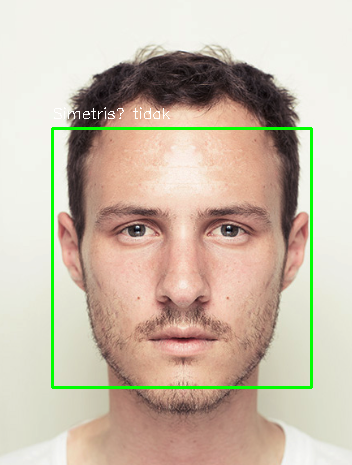

In [29]:
draw_face_bounding_box(test_image_path, f'Simetris? {pred_class}')